In this notebook we try to use the flow network for simulations

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import sys

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2022-03-07 17:20:29.944266: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/fvae_miniconda/lib/:
2022-03-07 17:20:29.944322: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sys.path.insert(0,'../')
from scripts.FlowVAEnet import FlowVAEnet
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm

In [3]:
tfd = tfp.distributions
tfb = tfp.bijectors

## Load trained models

In [5]:
flow_net = FlowVAEnet(latent_dim=32, linear_norm=True)
flow_net.load_flow_weights(weights_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/2step_scheduled_lr/fvae/')
flow_net.load_vae_weights(weights_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/2step_scheduled_lr/vae/val_loss')

print(flow_net.vae_model.summary())

in cropping


2022-03-07 22:49:26.595594: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 59, 59, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 560)               3741224   
_________________________________________________________________
multivariate_normal_tri_l_1  ((None, 32), (None, 32))  0         
_________________________________________________________________
decoder (Functional)         (None, 59, 59, 6)         4577196   
Total params: 8,318,420
Trainable params: 8,318,408
Non-trainable params: 12
_________________________________________________________________
None


### sample Latent space

sample form the base distribution, apply the bijector and then feed it to the decoder. 
Ideally, it should generate the image of a galaxy

In [6]:
zdist = tfd.Independent(
        tfd.Normal(loc=tf.zeros(32), scale=1), reinterpreted_batch_ndims=1
    )
base_sample = zdist.sample(10)

In [7]:
simulation = flow_net.decoder(flow_net.bijector.inverse(tf.reshape(base_sample,(10, 32)))).mean().numpy()

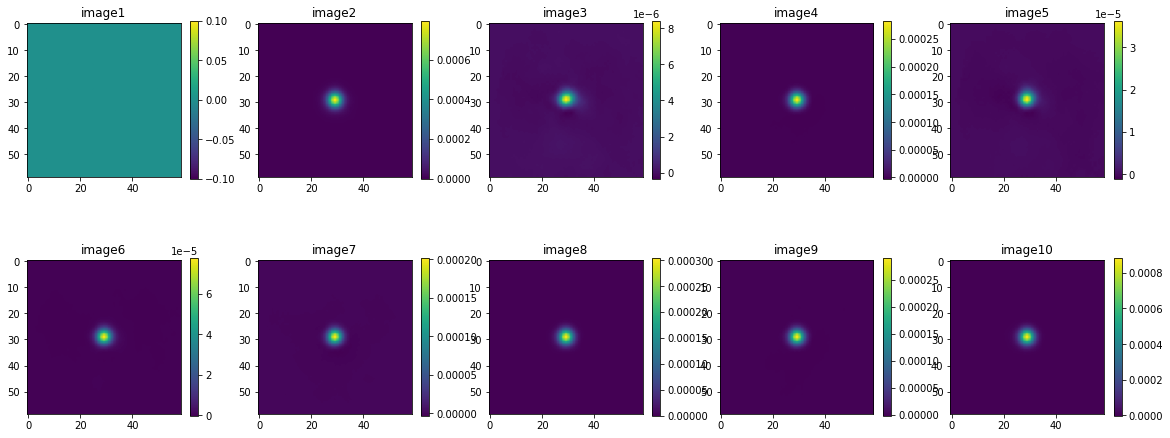

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(20,8))

for plot_row in range(2):
    for plot_col in range(5):

        im = axs[plot_row][plot_col].imshow(simulation[plot_row*5+plot_col, :, :, 2]-simulation[0, :, :, 2])
        fig.colorbar(im, ax=axs[plot_row][plot_col], shrink=0.8)
        axs[plot_row][plot_col].set_title("image" + str(plot_row*5+plot_col+1))